In [2]:
import numpy as np


# 초성, 중성, 종성 리스트
CHOSUNG_LIST = [
    "ㄱ",
    "ㄲ",
    "ㄴ",
    "ㄷ",
    "ㄸ",
    "ㄹ",
    "ㅁ",
    "ㅂ",
    "ㅃ",
    "ㅅ",
    "ㅆ",
    "ㅇ",
    "ㅈ",
    "ㅉ",
    "ㅊ",
    "ㅋ",
    "ㅌ",
    "ㅍ",
    "ㅎ",
]
JUNGSUNG_LIST = [
    "ㅏ",
    "ㅐ",
    "ㅑ",
    "ㅒ",
    "ㅓ",
    "ㅔ",
    "ㅕ",
    "ㅖ",
    "ㅗ",
    "ㅘ",
    "ㅙ",
    "ㅚ",
    "ㅛ",
    "ㅜ",
    "ㅝ",
    "ㅞ",
    "ㅟ",
    "ㅠ",
    "ㅡ",
    "ㅢ",
    "ㅣ",
]
JONGSUNG_LIST = [
    "",
    "ㄱ",
    "ㄲ",
    "ㄳ",
    "ㄴ",
    "ㄵ",
    "ㄶ",
    "ㄷ",
    "ㄹ",
    "ㄺ",
    "ㄻ",
    "ㄼ",
    "ㄽ",
    "ㄾ",
    "ㄿ",
    "ㅀ",
    "ㅁ",
    "ㅂ",
    "ㅄ",
    "ㅅ",
    "ㅆ",
    "ㅇ",
    "ㅈ",
    "ㅊ",
    "ㅋ",
    "ㅌ",
    "ㅍ",
    "ㅎ",
]


def one_hot_hangul(char):
    """
    한글 한 글자를 초성, 중성, 종성으로 분해하여 리스트로 반환합니다.
    """
    # 한글 음절의 유니코드 시작점과 끝점
    HANGUL_START = 0xAC00
    HANGUL_END = 0xD7A3

    # 입력된 문자의 유니코드 값
    char_code = ord(char)

    # 한글 음절 범위에 있는지 확인
    if HANGUL_START <= char_code <= HANGUL_END:
        # 초성, 중성, 종성 인덱스 계산 (중성 개수 = 21, 종성 개수 = 28)
        relative_code = char_code - HANGUL_START
        chosung_index = relative_code // (21 * 28)
        jungsung_index = (relative_code % (21 * 28)) // 28
        jongsung_index = relative_code % 28

        # 원-핫 인코딩 [19개 초성 | 21개 중성 | 28개 종성]으로 구성된 벡터 만들기
        # 인코딩의 각 초성 중성 종성의 위치는 위 CHOSUNG_LIST, JUNGSUNG_LIST, JONGSUNG_LIST와 같음
        encoding = np.zeros((68,), np.bool_)

        # 각  1로 바꾸기
        encoding[chosung_index] = 1
        encoding[19 + jungsung_index] = 1
        encoding[19 + 21 + jongsung_index] = 1

        return encoding
    else:
        # 한글 음절이 아니면 오류
        raise ValueError("입력이 한글이 아닙니다!")


2025-11-10 01:23:26.590618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


📎 Input: /home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg
✅ Resized & padded (white background)


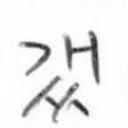

✅ Blurred


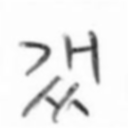

✅ Binary threshold result


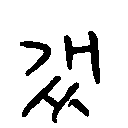

📎 Input: /home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg
✅ Resized & padded (white background)


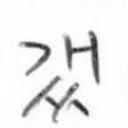

✅ Blurred


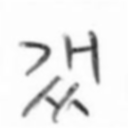

✅ Binary threshold result


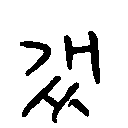

In [3]:
import tensorflow as tf
from IPython.display import display
from PIL import Image
import numpy as np

IMG_SIZE = 128
THRESHOLD = 0.8

def preprocess_for_view(path, threshold = THRESHOLD):
    bytes_ = tf.io.read_file(path)
    img = tf.image.decode_jpeg(bytes_, channels=1)  # original size (H, W, 1)

    # normalize [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    # ----------- ✅ padded resize with white background (1.0) -----------
    h, w, _ = img.shape
    scale = tf.minimum(IMG_SIZE / h, IMG_SIZE / w)
    nh = tf.cast(tf.round(h * scale), tf.int32)
    nw = tf.cast(tf.round(w * scale), tf.int32)

    img = tf.image.resize(img, (nh, nw))

    pad_top    = (IMG_SIZE - nh) // 2
    pad_bottom = IMG_SIZE - nh - pad_top
    pad_left   = (IMG_SIZE - nw) // 2
    pad_right  = IMG_SIZE - nw - pad_left

    # pad with 1.0 → white background
    img = tf.pad(img, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=1.0)

    # ----------- blur & threshold -----------
    img_blur = tf.nn.avg_pool2d(img[None, ...], ksize=3, strides=1, padding='SAME')[0]
    bin_img = tf.where(img_blur > THRESHOLD, 1.0, 0.0)

    return img, img_blur, bin_img

def show_preprocess_steps(path, threshold):
    raw, blur, binary = preprocess_for_view(path, threshold)

    def show_tensor(t):
        img = (t.numpy().squeeze() * 255).astype(np.uint8)
        display(Image.fromarray(img))

    print("📎 Input:", path)
    print("✅ Resized & padded (white background)")
    show_tensor(raw)

    print("✅ Blurred")
    show_tensor(blur)

    print("✅ Binary threshold result")
    show_tensor(binary)

show_preprocess_steps(r"/home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg", 0.8)
show_preprocess_steps(r"/home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg", 0.75)

In [4]:
import os, json, tensorflow as tf
import numpy as np
from typing import Literal

ROOT_DIR = r"/home/voxfish_ljy$/virtual/1.글자"
OUT_DIR  = r"/home/voxfish_ljy$/virtual/Data"
BATCH_SIZE = 256
IMG_SIZE   = 128
THRESHOLD  = 0.8
SHARD_SIZE = 10000
SAVE_DTYPE: Literal["uint8", "float32"] = "uint8"

# (선택) 아주 약한 노이즈 완화용 블러 사용 여부/크기
USE_BLUR = True
BLUR_KSIZE = 3   # 3 또는 5 권장 (avg_pool2d 대체)

def read_one_hot_from_json_py(json_path_tensor):
    # Eager 텐서를 Python str로
    path = json_path_tensor.numpy().decode("utf-8")
    path = os.path.normpath(path)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    ch = data["text"]["letter"]["value"]
    return one_hot_hangul(ch).astype(np.float32)

def read_one_hot_from_json_tf(json_path: tf.Tensor) -> tf.Tensor:
    vec = tf.py_function(
        func=read_one_hot_from_json_py,
        inp=[json_path],
        Tout=tf.float32
    )
    vec.set_shape((68,))
    return vec

def _resize_with_white_pad_01(img: tf.Tensor, out_size: int) -> tf.Tensor:
    """
    img: [H,W,1] float32 in [0,1]
    out: [out_size, out_size, 1] float32 in [0,1], 흰색(1.0) 패딩
    """
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    h_f = tf.cast(h, tf.float32)
    w_f = tf.cast(w, tf.float32)

    scale = tf.minimum(out_size / h_f, out_size / w_f)
    nh = tf.cast(tf.math.round(h_f * scale), tf.int32)
    nw = tf.cast(tf.math.round(w_f * scale), tf.int32)

    resized = tf.image.resize(img, (nh, nw), method="bilinear")

    pad_top    = (out_size - nh) // 2
    pad_bottom = out_size - nh - pad_top
    pad_left   = (out_size - nw) // 2
    pad_right  = out_size - nw - pad_left

    # 흰색(1.0)으로 패딩
    padded = tf.pad(
        resized,
        paddings=[[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]],
        mode="CONSTANT",
        constant_values=1.0,
    )
    return padded

def load_and_preprocess_image(img_path: tf.Tensor) -> tf.Tensor:
    """
    JPEG → grayscale → [0,1] → 비율 리사이즈 + 흰색패딩 → (선택)블러 → threshold 이진화(0/1)
    반환: [IMG_SIZE, IMG_SIZE, 1] float32 (0.0 또는 1.0)
    """
    bytes_ = tf.io.read_file(img_path)
    img_u8 = tf.image.decode_jpeg(bytes_, channels=1)        # [H,W,1] uint8
    img = tf.cast(img_u8, tf.float32) / 255.0               # [0,1] float32

    # 0(검정) 대신 1(흰색)으로 패딩
    img = _resize_with_white_pad_01(img, IMG_SIZE)

    # (선택) 아주 얕은 블러: avg_pool2d로 근사 (커널 3 또는 5)
    if USE_BLUR and BLUR_KSIZE > 1:
        # tf.nn.avg_pool2d는 입력을 [N,H,W,C]로 기대
        img = tf.nn.avg_pool2d(img[None, ...], ksize=BLUR_KSIZE, strides=1, padding="SAME")[0]

    # 이진화 (임계값 초과 → 1.0, 아니면 0.0)
    bin_img = tf.where(img > THRESHOLD, 1.0, 0.0)
    return bin_img

def to_json_path(img_path: tf.Tensor) -> tf.Tensor:
    """
    이미지 경로 → 동일 파일명 .json 경로
    (확장자 제거 후 .json)
    """
    p = tf.strings.regex_replace(img_path, r"\\", "/")
    dirname  = tf.strings.regex_replace(p, r"/[^/]+$", "/")
    basename = tf.strings.regex_replace(p, r"^.*/", "")
    stem     = tf.strings.regex_replace(basename, r"\.[^.]+$", "")
    return tf.strings.join([dirname, stem, ".json"])

def make_pair(img_path: tf.Tensor):
    json_path = to_json_path(img_path)
    x = load_and_preprocess_image(img_path)   # (IMG_SIZE, IMG_SIZE, 1) float32 0/1
    y = read_one_hot_from_json_tf(json_path)  # (68,) float32
    return x, y

def build_dataset(root_dir: str, batch_size=256, shuffle=True, cache=True) -> tf.data.Dataset:
    # 하위 폴더/*/*.jpg | *.jpeg | (대소문자 포함)
    pats = [
        os.path.join(root_dir, "*", "*.jpg"),
        os.path.join(root_dir, "*", "*.jpeg"),
        os.path.join(root_dir, "*", "*.JPG"),
        os.path.join(root_dir, "*", "*.JPEG"),
    ]
    ds = tf.data.Dataset.list_files(pats, shuffle=shuffle)
    ds = ds.map(make_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if cache:   ds = ds.cache()
    if shuffle: ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def save_dataset_to_numpy_shards(
    dataset: tf.data.Dataset,
    out_dir: str,
    shard_size: int = 50_000,
    save_dtype: Literal["uint8","float32"] = "uint8",
    verbose: bool = True,
):
    os.makedirs(out_dir, exist_ok=True)
    H, W, C = IMG_SIZE, IMG_SIZE, 1

    if save_dtype == "uint8":
        X_buf = np.empty((shard_size, H, W, C), dtype=np.uint8)
    else:
        X_buf = np.empty((shard_size, H, W, C), dtype=np.float32)
    Y_buf = np.empty((shard_size, 68), dtype=np.float32)

    shard_idx = 0
    in_shard = 0
    total = 0

    def flush():
        nonlocal shard_idx, in_shard, X_buf, Y_buf
        np.save(os.path.join(out_dir, f"X_shard_{shard_idx:03d}.npy"), X_buf[:in_shard])
        np.save(os.path.join(out_dir, f"Y_shard_{shard_idx:03d}.npy"), Y_buf[:in_shard])
        if verbose:
            print(f"saved shard {shard_idx:03d}: {in_shard} samples")
        shard_idx += 1
        in_shard = 0
        # 새 버퍼
        if save_dtype == "uint8":
            X_buf = np.empty((shard_size, H, W, C), dtype=np.uint8)
        else:
            X_buf = np.empty((shard_size, H, W, C), dtype=np.float32)
        Y_buf = np.empty((shard_size, 68), dtype=np.float32)

    for bi, (imgs, labels) in enumerate(dataset):
        X = imgs.numpy()    # (B, IMG_SIZE, IMG_SIZE, 1) float32 (0/1)
        Y = labels.numpy()  # (B, 68) float32

        if save_dtype == "uint8":
            # 0/1 → 0/255로 저장 (이진 유지)
            X = (np.clip(X, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)
        else:
            X = X.astype(np.float32, copy=False)
        Y = Y.astype(np.float32, copy=False)

        B = X.shape[0]
        off = 0
        while off < B:
            take = min(shard_size - in_shard, B - off)
            X_buf[in_shard:in_shard+take] = X[off:off+take]
            Y_buf[in_shard:in_shard+take] = Y[off:off+take]
            in_shard += take
            off += take
            total += take
            if in_shard == shard_size:
                flush()

        if verbose and (bi % 50 == 0):
            print(f"[batch {bi}] total={total}, shard={shard_idx:03d}, in_shard={in_shard}")

    if in_shard > 0:
        flush()

    if verbose:
        print(f"Done. Total samples saved: {total}")

if __name__ == "__main__":
    print("→ Building dataset from:", ROOT_DIR)
    ds = build_dataset(ROOT_DIR, batch_size=BATCH_SIZE, shuffle=True, cache=True)

    print("→ Saving shards to:", OUT_DIR)
    save_dataset_to_numpy_shards(
        ds,
        out_dir=OUT_DIR,
        shard_size=SHARD_SIZE,
        save_dtype=SAVE_DTYPE,
        verbose=True,
    )

    print("All done.")

→ Building dataset from: /home/voxfish_ljy$/virtual/1.글자
→ Saving shards to: /home/voxfish_ljy$/virtual/Data
[batch 0] total=256, shard=000, in_shard=256
saved shard 000: 10000 samples
[batch 50] total=13056, shard=001, in_shard=3056
saved shard 001: 10000 samples
[batch 100] total=25856, shard=002, in_shard=5856
saved shard 002: 10000 samples
[batch 150] total=38656, shard=003, in_shard=8656
saved shard 003: 10000 samples
saved shard 004: 10000 samples
[batch 200] total=51456, shard=005, in_shard=1456
saved shard 005: 10000 samples
[batch 250] total=64256, shard=006, in_shard=4256
saved shard 006: 10000 samples
[batch 300] total=77056, shard=007, in_shard=7056
saved shard 007: 10000 samples
[batch 350] total=89856, shard=008, in_shard=9856
saved shard 008: 10000 samples
saved shard 009: 10000 samples
[batch 400] total=102656, shard=010, in_shard=2656
saved shard 010: 10000 samples
[batch 450] total=115456, shard=011, in_shard=5456
saved shard 011: 10000 samples
[batch 500] total=12825

2025-11-10 01:28:07.257674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
import os, glob, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# ======= 하이퍼파라미터 =======
IMG_SIZE     = 128
NUM_CLASSES  = 68                 # [초성19 | 중성21 | 종성28]
BATCH_SIZE   = 128
EPOCHS       = 300
INIT_LR      = 1e-3
TRAIN_RATIO  = 0.75
ALPHA        = 0.75               # MobileNetV2 width multiplier
AUG_ON       = True               # 증강 on/off
MODE         = "stem"             # "stem" (권장) | "native"
OUT_DIR      = "./runs_MobileNetV2"
SHARD_DIR    = r"/home/voxfish_ljy$/virtual/Data"   # <<< 여기를 변경

AUTOTUNE     = tf.data.AUTOTUNE

# ======= L/V/T 슬라이스 인덱스 =======
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

# ---------------------------------------------------------
# 증강
# ---------------------------------------------------------
def hangul_ocr_augment():
    return tf.keras.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.15, 0.15),
        layers.RandomZoom(0.20),
        layers.RandomHeight(0.10),
        layers.RandomWidth(0.10),
    ], name="hangul_aug")

# ---------------------------------------------------------
# 모델
# ---------------------------------------------------------
def build_mobilenetv2(mode="stem", alpha=0.75, dropout=0.25, aug=True):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="image")
    x = layers.Rescaling(2.0, offset=-1.0, name="to_minus1_1")(inp)
    if aug:
        x = hangul_ocr_augment()(x)

    if mode == "native":
        base = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 1),
            include_top=False, weights=None, alpha=alpha, pooling="avg",
        )
        h = base(x)
    else:
        # 1채널 -> 3채널 투영(호환성↑)
        x3 = layers.Conv2D(3, 1, padding="same", use_bias=False, name="stem_1x1")(x)
        base = tf.keras.applications.MobileNetV2(
            input_tensor=x3, include_top=False, weights=None, alpha=alpha, pooling="avg",
        )
        h = base.output

    h = layers.Dropout(dropout, name="head_dropout")(h)
    out = layers.Dense(NUM_CLASSES, activation=None, name="char68", dtype="float32")(h)
    return models.Model(inp, out, name=f"mobilenetv2_{mode}")

# ---------------------------------------------------------
# 커스텀 메트릭(학습 로그에 바로 표기)
# ---------------------------------------------------------
def acc_first(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1)),
            tf.float32
        )
    )

def acc_middle(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1)),
            tf.float32
        )
    )

def acc_last(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1)),
            tf.float32
        )
    )

def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# ---------------------------------------------------------
# 샤드 → tf.data
# ---------------------------------------------------------
def _per_shard_dataset(x_path, y_path, shuffle_inside=True):
    # 메모리는 memmap 유지 (RAM 폭증 방지)
    X = np.load(x_path, mmap_mode="r")   # (N,150,150,1) uint8
    Y = np.load(y_path, mmap_mode="r")   # (N,68) float32
    n = X.shape[0]

    # 인덱스 스트림을 만들고, 인덱스로 memmap에 접근
    ds = tf.data.Dataset.from_tensor_slices(tf.range(n, dtype=tf.int64))
    if shuffle_inside:
        ds = ds.shuffle(8192)

    def _load_one_py(i):
        i = int(i)
        return X[i], Y[i]   # numpy 배열 반환 (uint8, float32)

    def _load_one(i):
        xi, yi = tf.py_function(
            _load_one_py, [i], [tf.uint8, tf.float32]
        )
        # 정적 shape 명시 (그래프 추론 도움)
        xi.set_shape((IMG_SIZE, IMG_SIZE, 1))
        yi.set_shape((NUM_CLASSES,))
        # 전처리
        x = tf.cast(xi, tf.float32)
        x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x / 255.0, lambda: x)
        y = yi
        return x, y

    ds = ds.map(_load_one, num_parallel_calls=AUTOTUNE)
    return ds

def build_ds_from_numpy_shards(
    shard_dir: str,
    batch_size: int = 256,
    train_ratio: float = 0.9,
    interleave_across_shards: bool = True,
    repeat: bool = False,
    shuffle_files: bool = True,
):
    X_files = sorted(glob.glob(os.path.join(shard_dir, "X_shard_*.npy")))
    Y_files = sorted(glob.glob(os.path.join(shard_dir, "Y_shard_*.npy")))
    assert len(X_files) == len(Y_files) and len(X_files) > 0, "샤드 파일이 없거나 개수가 불일치합니다."

    idxs = list(range(len(X_files)))
    if shuffle_files:
        random.shuffle(idxs)

    split = int(len(idxs) * train_ratio)
    train_idx, val_idx = idxs[:split], idxs[split:]

    def make_combo(idxs, shuffle_inside=True):
        shards = [_per_shard_dataset(X_files[i], Y_files[i], shuffle_inside=shuffle_inside) for i in idxs]
        if interleave_across_shards and len(shards) > 1:
            ds = tf.data.Dataset.sample_from_datasets(shards)
        else:
            ds = shards[0]
            for s in shards[1:]:
                ds = ds.concatenate(s)
        if repeat:
            ds = ds.repeat()
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds

    train_ds = make_combo(train_idx, shuffle_inside=True)
    val_ds   = make_combo(val_idx, shuffle_inside=False) if val_idx else None
    return train_ds, val_ds, len(train_idx), len(val_idx)

# ---------------------------------------------------------
# 오프라인 평가 (원하는 시점에 호출)
# ---------------------------------------------------------
def eval_lvt_metrics(model, dataset, max_batches=None):
    L_right = V_right = T_right = Joint_right = 0
    total = 0
    for b, (X, Y) in enumerate(dataset):
        P = model.predict(X, verbose=0)  # (B,68)

        yL = np.argmax(Y[:, L_SLICE], axis=1)
        yV = np.argmax(Y[:, V_SLICE], axis=1)
        yT = np.argmax(Y[:, T_SLICE], axis=1)

        pL = np.argmax(P[:, L_SLICE], axis=1)
        pV = np.argmax(P[:, V_SLICE], axis=1)
        pT = np.argmax(P[:, T_SLICE], axis=1)

        L_right += np.sum(yL == pL)
        V_right += np.sum(yV == pV)
        T_right += np.sum(yT == pT)
        Joint_right += np.sum((yL == pL) & (yV == pV) & (yT == pT))
        total += X.shape[0]

        if max_batches is not None and (b + 1) >= max_batches:
            break

    return {
        "acc_first": L_right / total,
        "acc_mid": V_right / total,
        "acc_last": T_right / total,
        "acc_joint": Joint_right / total,
        "samples": total,
    }

# ---------------------------------------------------------
# 학습 루틴
# ---------------------------------------------------------
def compile_and_train():
    os.makedirs(OUT_DIR, exist_ok=True)

    # 1) 데이터
    train_ds, val_ds, n_tr, n_va = build_ds_from_numpy_shards(
        shard_dir=SHARD_DIR,
        batch_size=BATCH_SIZE,
        train_ratio=TRAIN_RATIO,
        interleave_across_shards=True,
        repeat=False,
        shuffle_files=True,
    )
    print(f"train shards: {n_tr}, val shards: {n_va}")

    def hangul_loss(y_true, logits):
        cho = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, L_SLICE],
            logits = logits[:, L_SLICE]
        )
        jung = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, V_SLICE],
            logits = logits[:, V_SLICE]
        )
        jong = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, T_SLICE],
            logits = logits[:, T_SLICE]
        )
        return cho+jung+jong
    # 2) 모델
    model = build_mobilenetv2(mode=MODE, alpha=ALPHA, dropout=0.25, aug=AUG_ON)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(INIT_LR),
        loss=hangul_loss,
        metrics=[acc_first, acc_middle, acc_last, acc_joint],
    )
    model.summary()

    # 3) 콜백
    ckpt_path = os.path.join(OUT_DIR, "ckpt_best.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path, monitor="val_acc_joint",
            save_best_only=True, save_weights_only=False, mode="max"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=3e-6, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.CSVLogger(os.path.join(OUT_DIR, "train.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(OUT_DIR, "tb")),
    ]

    # 4) 학습
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    # 5) 최종 저장
    model.save(os.path.join(OUT_DIR, "final.keras"))

    # 6) 검증 세트에서 L/V/T/Joint 지표 출력
    if val_ds is not None:
        metrics = eval_lvt_metrics(model, val_ds)
        print("\n========== L/V/T/Joint metrics on VAL ==========")
        print(f"Samples   : {metrics['samples']}")
        print(f"초성 정확도 : {metrics['acc_first']}")
        print(f"중성 정확도 : {metrics['acc_mid']}")
        print(f"종성 정확도 : {metrics['acc_last']}")
        print(f"총 정확도   : {metrics['acc_joint']}")
        print("===============================================\n")

    return model, history, (train_ds, val_ds)

# ---------------------------------------------------------
# 실행
# ---------------------------------------------------------
if __name__ == "__main__":
    # (선택) 혼합정밀도: 지원 GPU면 주석 해제
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    compile_and_train()

KeyboardInterrupt: 

In [7]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # 안 쓰고 싶으면 아래 No-MPL 코드도 줄게
import os

# --- L/V/T slice index (68차원 기준) ---
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

# --- Loss (초/중/종성 cross entropy 합산) ---
def hangul_loss(y_true, logits):
    cho  = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, L_SLICE], logits=logits[:, L_SLICE])
    jung = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, V_SLICE], logits=logits[:, V_SLICE])
    jong = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, T_SLICE], logits=logits[:, T_SLICE])
    return cho + jung + jong

# --- Metrics ---
def acc_first(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1)),
            tf.float32
        )
    )

def acc_middle(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1)),
            tf.float32
        )
    )

def acc_last(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1)),
            tf.float32
        )
    )

def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# --- 모델 로드 ---
model = tf.keras.models.load_model(
    r"C:\Users\user\Documents\GitHub\Hangul-to-Unicode-Obfuscation-Project\working\runs_MobileNetV2\final.keras",
    custom_objects={
        "acc_first": acc_first,
        "acc_middle": acc_middle,
        "acc_last": acc_last,
        "acc_joint": acc_joint,
        "hangul_loss": hangul_loss
    }
)

IMG_SIZE = 128
THRESHOLD = 0.8

# 초성/중성/종성 리스트
CHOSUNG_LIST = ["ㄱ","ㄲ","ㄴ","ㄷ","ㄸ","ㄹ","ㅁ","ㅂ","ㅃ","ㅅ","ㅆ","ㅇ","ㅈ","ㅉ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]
JUNGSUNG_LIST = ["ㅏ","ㅐ","ㅑ","ㅒ","ㅓ","ㅔ","ㅕ","ㅖ","ㅗ","ㅘ","ㅙ","ㅚ","ㅛ","ㅜ","ㅝ","ㅞ","ㅟ","ㅠ","ㅡ","ㅢ","ㅣ"]
JONGSUNG_LIST = ["","ㄱ","ㄲ","ㄳ","ㄴ","ㄵ","ㄶ","ㄷ","ㄹ","ㄺ","ㄻ","ㄼ","ㄽ","ㄾ","ㄿ","ㅀ","ㅁ","ㅂ","ㅄ","ㅅ","ㅆ","ㅇ","ㅈ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]

# --- 단일 이미지 전처리 함수 ---
def preprocess_for_test(img_path: str):
    bytes_ = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(bytes_, channels=1)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)

    img = tf.cast(img, tf.float32) / 255.0
    img = tf.where(img > THRESHOLD, 1.0, 0.0)  # binary

    return img[None, ...]  # (1, H, W, 1)

# --- 예측 함수 ---
def predict_hangul(img_path):
    x = preprocess_for_test(img_path)
    pred = model.predict(x)[0]  # shape (68,)

    # 각 범위 slicing
    pL = np.argmax(pred[0:19])
    pV = np.argmax(pred[19:40])
    pT = np.argmax(pred[40:68])

    print("파일:", img_path)
    print(f"예측 초성: {CHOSUNG_LIST[pL]}")
    print(f"예측 중성: {JUNGSUNG_LIST[pV]}")
    print(f"예측 종성: {JONGSUNG_LIST[pT] if JONGSUNG_LIST[pT] != '' else '없음'}")

    # 시각 확인
    img = Image.open(img_path).convert("L")
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # 전처리된 결과도 보기
    bin_img = x.numpy().reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(bin_img, cmap="gray")
    plt.title("Preprocessed (Binary)")
    plt.axis("off")
    plt.show()

# 🔥 테스트 실행
test_img = r"C:\Users\user\Documents\GitHub\Hangul-to-Unicode-Obfuscation-Project\구자라트어 엉.jpg"  # 👈 파일 경로 넣기
predict_hangul(test_img)

ModuleNotFoundError: No module named 'tensorflow'

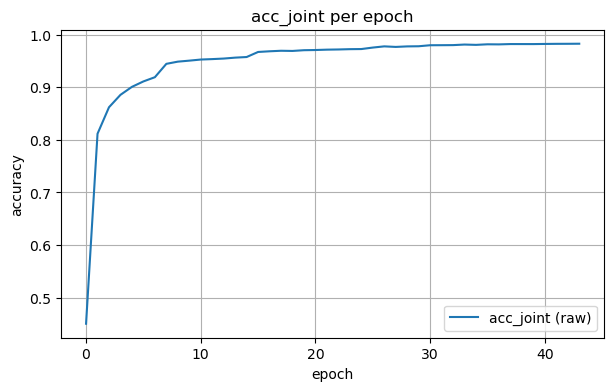

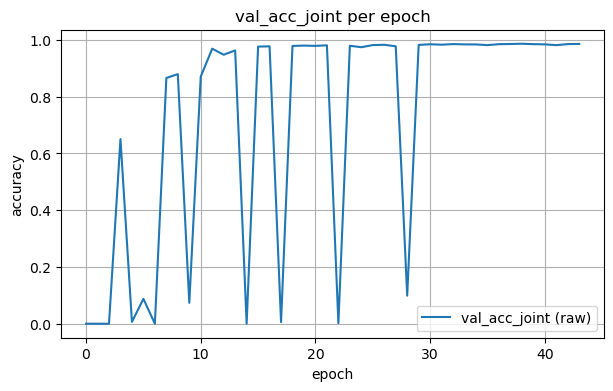

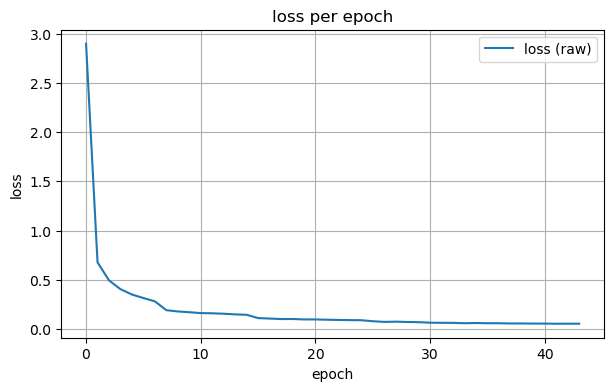

In [5]:
# === 설정 ===
LOG_DIR  = "./runs_MobileNetV2"          # train.csv가 있는 폴더
LOG_PATH = f"{LOG_DIR}/train.csv"
SMOOTH   = 1   # 이동평균(스무딩) 윈도우 크기. 1이면 원본값만 사용

import os
import pandas as pd
import numpy as np

# 1) CSV 로드
if not os.path.exists(LOG_PATH):
    raise FileNotFoundError(f"train.csv를 찾을 수 없습니다: {LOG_PATH}")

df = pd.read_csv(LOG_PATH)

# 2) 에포크 축 만들기 (CSVLogger가 epoch 컬럼을 넣어줍니다)
if "epoch" in df.columns:
    epoch = df["epoch"].to_numpy()
else:
    epoch = np.arange(len(df), dtype=int)

# 3) 필요한 컬럼 확인
need_cols = ["acc_joint", "val_acc_joint", "loss"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    print("train.csv에 아래 컬럼이 없습니다:", missing)
    print("사용 가능한 컬럼들:", list(df.columns))
    raise SystemExit

acc_joint     = df["acc_joint"].to_numpy()
val_acc_joint = df["val_acc_joint"].to_numpy()
loss          = df["loss"].to_numpy()

# 4) 스무딩(옵션)
def smooth(x, k):
    if k <= 1: 
        return x
    return pd.Series(x).rolling(k, min_periods=1, center=True).mean().to_numpy()

acc_s   = smooth(acc_joint, SMOOTH)
val_s   = smooth(val_acc_joint, SMOOTH)
loss_s  = smooth(loss, SMOOTH)

# 5) 그래프 출력
import matplotlib.pyplot as plt

# (1) acc_joint
plt.figure(figsize=(7,4))
plt.plot(epoch, acc_joint, label="acc_joint (raw)")
if SMOOTH > 1:
    plt.plot(epoch, acc_s, label=f"acc_joint (smooth {SMOOTH})")
plt.title("acc_joint per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# (2) val_acc_joint
plt.figure(figsize=(7,4))
plt.plot(epoch, val_acc_joint, label="val_acc_joint (raw)")
if SMOOTH > 1:
    plt.plot(epoch, val_s, label=f"val_acc_joint (smooth {SMOOTH})")
plt.title("val_acc_joint per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# (3) loss
plt.figure(figsize=(7,4))
plt.plot(epoch, loss, label="loss (raw)")
if SMOOTH > 1:
    plt.plot(epoch, loss_s, label=f"loss (smooth {SMOOTH})")
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

In [144]:
import os
import glob
import numpy as np
import tensorflow as tf

# === 설정 ===
MODEL_PATH = "./runs_MobileNetV2/final.keras"
INPUT_DIR  = "/home/voxfish_ljy$/virtual/Unicodes"     # unicode_tensors_N.npy가 들어 있는 폴더
OUTPUT_DIR = "/home/voxfish_ljy$/virtual/Unicodes"    # unicode_results_N.npy를 저장할 폴더
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 필요한 custom_objects 정의 ---
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

def hangul_loss(y_true, logits):
    cho  = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, L_SLICE], logits=logits[:, L_SLICE])
    jung = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, V_SLICE], logits=logits[:, V_SLICE])
    jong = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, T_SLICE], logits=logits[:, T_SLICE])
    return cho + jung + jong

def acc_first(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, L_SLICE], -1),
                                           tf.argmax(y_pred[:, L_SLICE], -1)), tf.float32))
def acc_middle(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, V_SLICE], -1),
                                           tf.argmax(y_pred[:, V_SLICE], -1)), tf.float32))
def acc_last(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, T_SLICE], -1),
                                           tf.argmax(y_pred[:, T_SLICE], -1)), tf.float32))
def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# --- 모델 로드 ---
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "hangul_loss": hangul_loss,
        "acc_first": acc_first,
        "acc_middle": acc_middle,
        "acc_last": acc_last,
        "acc_joint": acc_joint,
    }
)
print("✅ Model loaded.")

# --- 입력 파일 목록 ---
input_files = sorted(glob.glob(os.path.join(INPUT_DIR, "combined_unicode_tensors_*.npy")))
if not input_files:
    raise FileNotFoundError("입력 폴더에 combined_unicode_tensors_*.npy 파일이 없습니다.")

for f_in in input_files:
    base = os.path.basename(f_in)                   # unicode_tensors_N.npy
    f_out = base.replace("combined_unicode_tensors_", "combined_unicode_results_")
    out_path = os.path.join(OUTPUT_DIR, f_out)

    # 입력 데이터 로드
    X = np.load(f_in)                               # shape: (N, 128,128,1)
    if X.ndim == 3:
        X = np.expand_dims(X, -1)
    X = X.astype(np.float32)
    if np.max(X) > 1.5:
        X /= 255.0                                  # 정규화

    print(f"▶ Predicting {f_in} -> {out_path} (shape={X.shape})")

    # 모델 예측
    preds = model.predict(X, batch_size=256, verbose=1)  # (N,68)

    # 결과 저장
    np.save(out_path, preds.astype(np.float32))
    print(f"✅ Saved {out_path}\n")

print("🎉 모든 파일 처리 완료!")

✅ Model loaded.
▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_0.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_0.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_0.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_1.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_1.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_1.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_10.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_10.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_10.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_11.npy -> /home/voxfis

[Shard 10, Index 920]
입력 이미지:


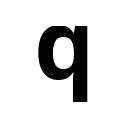


예측된 초성/중성/종성 (argmax 기준): ㅇㅣ


In [142]:
import os, glob, random
import numpy as np
import tensorflow as tf
from IPython.display import Image, display

# ===== 경로 설정(필요에 맞게 수정) =====
TENSOR_DIR = r"/home/voxfish_ljy$/virtual/Unicodes"   # unicode_tensors_*.npy 있는 폴더
RESULT_DIR = r"/home/voxfish_ljy$/virtual/Unicodes"   # unicode_results_*.npy 있는 폴더

# 68차원 벡터를 초/중/종성으로 해석하고 싶을 때만 사용 (선택)
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

CHOS = ["ㄱ","ㄲ","ㄴ","ㄷ","ㄸ","ㄹ","ㅁ","ㅂ","ㅃ","ㅅ","ㅆ","ㅇ","ㅈ","ㅉ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]
JUNS = ["ㅏ","ㅐ","ㅑ","ㅒ","ㅓ","ㅔ","ㅕ","ㅖ","ㅗ","ㅘ","ㅙ","ㅚ","ㅛ","ㅜ","ㅝ","ㅞ","ㅟ","ㅠ","ㅡ","ㅢ","ㅣ"]
JONGS = ["","ㄱ","ㄲ","ㄳ","ㄴ","ㄵ","ㄶ","ㄷ","ㄹ","ㄺ","ㄻ","ㄼ","ㄽ","ㄾ","ㄿ","ㅀ","ㅁ","ㅂ","ㅄ","ㅅ","ㅆ","ㅇ","ㅈ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]

def decode_LVT(vec):
    """68차원 벡터를 (초성, 중성, 종성) 문자로 대략 해석 (선택 기능)"""
    l_idx = np.argmax(vec[L_SLICE])
    v_idx = np.argmax(vec[V_SLICE])
    t_idx = np.argmax(vec[T_SLICE])
    return CHOS[l_idx], JUNS[v_idx], JONGS[t_idx]


def show_png_from_tensor(x):
    """
    (H,W) 또는 (H,W,1) 텐서를 Jupyter에 이미지로 표시
    x: numpy array, 값 범위가 0/1 또는 0~255라고 가정
    """
    arr = x
    if arr.ndim == 2:
        arr = arr[..., None]      # (H,W,1)로
    # 값 스케일 맞춰서 uint8로
    if arr.max() <= 1.0:
        arr = (arr * 255).astype(np.uint8)
    else:
        arr = arr.astype(np.uint8)
    png_bytes = tf.io.encode_png(tf.constant(arr)).numpy()
    display(Image(data=png_bytes))


def check_random_pair(tensor_dir=TENSOR_DIR, result_dir=RESULT_DIR):
    # 1) 파일 목록 수집
    tensor_files = sorted(glob.glob(os.path.join(tensor_dir, "unicode_tensors_*.npy"))) or sorted(glob.glob(os.path.join(tensor_dir, "combined_unicode_tensors_*.npy")))
    result_files = sorted(glob.glob(os.path.join(result_dir, "unicode_results_*.npy"))) or sorted(glob.glob(os.path.join(tensor_dir, "combined_unicode_results_*.npy")))

    assert len(tensor_files) > 0, "unicode_tensors_*.npy 파일이 없습니다."
    assert len(tensor_files) == len(result_files), "tensors와 results 샤드 개수가 다릅니다."

    # 2) 랜덤 샤드 선택
    shard_idx = random.randint(0, len(tensor_files) - 1)
    X = np.load(tensor_files[shard_idx], mmap_mode="r")   # (N,128,128,1) 또는 (N,128,128)
    R = np.load(result_files[shard_idx], mmap_mode="r")   # (N,68)

    assert X.shape[0] == R.shape[0], f"샤드 {shard_idx}의 샘플 수가 다릅니다: X={X.shape[0]}, R={R.shape[0]}"

    # 3) 랜덤 인덱스 선택
    i = random.randint(0, X.shape[0] - 1)
    x = X[i]
    vec = R[i]

    # 4) 입력 이미지 표시
    print(f"[Shard {shard_idx}, Index {i}]")
    print("입력 이미지:")
    show_png_from_tensor(x)

    # 선택: 초/중/종성으로 해석해서 보기 (vec이 그런 구조라면)
    try:
        l, v, t = decode_LVT(vec)
        print(f"\n예측된 초성/중성/종성 (argmax 기준): {l}{v}{t}")
    except Exception as e:
        print("\ndecode_LVT에서 오류 발생 (벡터 구조가 다를 수 있음):", e)

    return x, vec


# 실행 예시 (몇 번 돌려보면서 확인)
_ = check_random_pair()